In [1]:
from typing import List, Optional, Sequence, Set
import pandas as pd
import torch
import torch.nn as nn
import torch.utils.data as torch_data
from matplotlib import pyplot as plt

df = pd.read_csv("assets/diabetes.csv", sep="\t")
df['Class'] = pd.qcut(df.Y, 10, labels=False)

def visualize_deciles():
    fig = plt.figure()
    plt.scatter(df.Class, df.Y)
    ax = fig.axes[0]
    ax.set_xlabel("Class")
    ax.set_ylabel("Y")
    ax.set_title("Diabetes Y Classes")
    ax.set_xticks(range(10), (str(i+1) for i in range(10)))

# Our custom Dataset. Useful reference:
# https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
class DiabetesDataset(torch_data.Dataset):
    df: pd.DataFrame

    x_include: Set[str]
    y_column: str

    def __init__(self,
                 df: pd.DataFrame,
                 x_include: Sequence[str],
                 y_column: str
    ):
        self.df = df

        self.x_include = set(x_include)
        self.y_column = y_column

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index) -> torch.Tensor:
        x = self.df.loc[index, (col in self.x_include for col in df.columns)].values
        y = self.df.loc[index, df.columns == self.y_column].values
        return (
            torch.tensor(x).float(),
            torch.tensor(y).squeeze().long())

class ClassPredictor:
    dataloader: torch_data.DataLoader

    def __init__(self,
                 dataloader: torch_data.DataLoader,
                 in_features: int,
                 out_features: int = 10,
                 learning_rate: float = 0.1,
    ):
        self.dataloader = dataloader

        self.model = nn.Sequential(
            nn.Linear(in_features, in_features * 2),
            nn.ReLU(),
            nn.Linear(in_features * 2, out_features),
            nn.LogSoftmax(dim=1)
        )

        self.loss = nn.NLLLoss()

        self.optimizer = torch.optim.SGD(
            self.model.parameters(),
            lr=learning_rate)

    def forward_batch(self, batch):
        xs, ys = batch

        # new batch, zero all gradients
        self.optimizer.zero_grad()

        # feed forwad
        output = self.model(xs)

        # compute loss and gradients
        loss = self.loss(output, ys)
        loss.backward()

        # update model parameters
        self.optimizer.step()

        # calculate the accuracy.
        # `inferred_classes` gets, from each entry in the batch the highest probability class.
        # then, we count how many classes the model got right, and divide by total classes
        # in order to normalize for a relative error.
        inferred_classes = output.argmax(dim=1)
        accuracy = (inferred_classes == ys).sum() / len(ys)

        return loss.detach(), accuracy.detach()

    def forward(self):
        total_batches = len(self.dataloader)
        loss_overtime = torch.empty(total_batches)
        accuracy_overtime = torch.empty(total_batches)

        for idx, batch in enumerate(self.dataloader):
            loss, accuracy = self.forward_batch(batch)
            loss_overtime[idx] = loss
            accuracy_overtime[idx] = accuracy

        return loss_overtime.mean(), accuracy_overtime.mean()

    def train(self,
              epochs: int,
              plot: bool = False,
              plot_suptitle: Optional[str] = None,
        ):

        losses = torch.empty(epochs)
        accuracies = torch.empty(epochs)

        print("Training ", end="")
        for epoch in range(epochs):
            print(".", end="")
            loss, accuracy = self.forward()
            losses[epoch] = loss
            accuracies[epoch] = accuracy
        print()

        if plot:
            fig = plt.figure()
            if plot_suptitle:
                fig.suptitle(plot_suptitle)
            plt.subplot(1, 2, 1)
            plt.title("Loss")
            plt.plot(range(epochs), losses)
            plt.xlabel("Epoch")

            plt.subplot(1, 2, 2)
            plt.plot(range(epochs), accuracies)
            plt.title("Accuracy")
            plt.xlabel("Epoch")

epochs = 30
plot = True
lr = 0.01

[tensor([[ 59.0000,   2.0000,  32.1000, 101.0000, 157.0000,  93.2000,  38.0000,
           4.0000,   4.8598,  87.0000, 151.0000],
        [ 48.0000,   1.0000,  21.6000,  87.0000, 183.0000, 103.2000,  70.0000,
           3.0000,   3.8918,  69.0000,  75.0000],
        [ 72.0000,   2.0000,  30.5000,  93.0000, 156.0000,  93.6000,  41.0000,
           4.0000,   4.6728,  85.0000, 141.0000],
        [ 24.0000,   1.0000,  25.3000,  84.0000, 198.0000, 131.4000,  40.0000,
           5.0000,   4.8903,  89.0000, 206.0000],
        [ 50.0000,   1.0000,  23.0000, 101.0000, 192.0000, 125.4000,  52.0000,
           4.0000,   4.2905,  80.0000, 135.0000],
        [ 23.0000,   1.0000,  22.6000,  89.0000, 139.0000,  64.8000,  61.0000,
           2.0000,   4.1897,  68.0000,  97.0000],
        [ 36.0000,   2.0000,  22.0000,  90.0000, 160.0000,  99.6000,  50.0000,
           3.0000,   3.9512,  82.0000, 138.0000],
        [ 66.0000,   2.0000,  26.2000, 114.0000, 255.0000, 185.0000,  56.0000,
           4.5500

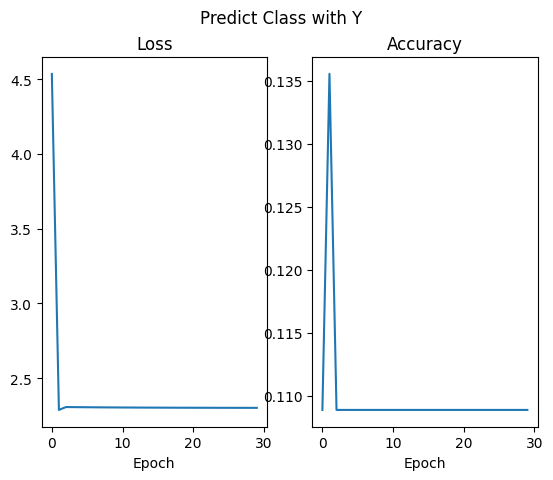

In [2]:
dataset_with_y = DiabetesDataset(
    df,
    x_include=[col for col in df.columns if col not in ("Class")],
    y_column="Class")

dataloader_with_y = torch_data.DataLoader(dataset_with_y, 10)

# print the first batch
print(next(iter(dataloader_with_y)))

predictor_with_y = ClassPredictor(
    dataloader=dataloader_with_y,
    in_features=len(df.columns) - 1,
    learning_rate=lr)

predictor_with_y.train(epochs, plot, plot_suptitle="Predict Class with Y")

Training ..............................


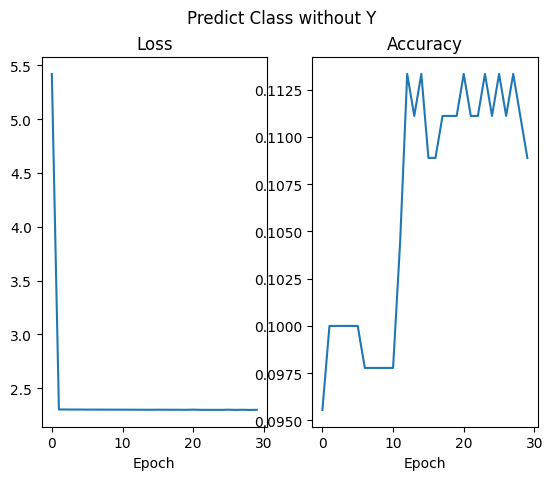

In [3]:

dataset_without_y = DiabetesDataset(
    df,
    x_include=[col for col in df.columns if col not in ("Class", "Y")],
    y_column="Class")

dataloader_without_y = torch_data.DataLoader(dataset_without_y, 10)

predictor_without_y = ClassPredictor(
    dataloader=dataloader_without_y,
    in_features=len(df.columns) - 2,
    learning_rate=lr)

predictor_without_y.train(epochs, plot, plot_suptitle="Predict Class without Y")